In [73]:
%matplotlib inline
import numpredict

#예제 데이터 세트 만들기 


이 장은 예전에 살펴 보았던 예제들을 가지고 숫자 예측용 학습을 수행하는 알고리즘을 살펴보고, 예측 방법에 대한 편리한 해석을 위해 예측에 대한 확률분포도 출력해 본다. 

##1. .예제 데이터 세트 만들기

숫자 예측 시험용 데이터 세트는 예측을 방해하는 속성들을 가지면 안됨

간단한 인공모델에 기반을 둔 와인 가격 데이터 세트를 작성. <br>가격은 등급과 나이를 조합하여 작성, <br> 이 모델에서는 와인이 최적연도를 가지고 있어, 출륭한 와인은 높은 가격에서 시작해서 최적 연도까지 계속 가치가 증가, 낮은 등급의 와인은 싸게 시작해서 점점 더 싸지게 된다.<br>이를 모델화 하기 위해 아래와 같은 함수를 만든다

In [2]:
from random import random,randint
import math 
def wineprice(rating, age):
    peak_age = rating - 50
    
    #등급에 따라 가격을 계산함
    price = rating /2
    if age > peak_age :
        #최적 연도가 지나면 5년 단위로 가격이 저하됨
        price = price * (5-(age-peak_age))
    else:
        #최적 연도에 근접하면 원래 가격의 5배까지 증가함
        price = price*(5*((age+1)/peak_age))
    if price <0 :
        price = 0
    return price
    
    

와인 가격 데이터 세트를 만들 함수 정의 <br>

In [3]:
def wineset1():
    rows = []
    for i in range(300):
        #무작위로 나이(숙성기간)와 등급을 생성함
        rating = random()*50+50
        age = random()*50
        
        #가격을 얻음
        price = wineprice(rating, age)
        
        #노이즈를 얻음
        price *= (random()*0.4 + 0.8)
        
        #데이터세트에 추가함
        rows.append({'input':(rating,age),'result':price})
    return rows


In [4]:
wineprice(95.0, 3.0)

21.111111111111114

In [5]:
wineprice(95.0, 8.0)

47.5

In [6]:
wineprice(99.0, 1.0)

10.102040816326529

In [7]:
data = wineset1()

In [8]:
data[0]

{'input': (61.62697948398507, 9.715516914732664), 'result': 120.25488294090106}

In [9]:
data[1]

{'input': (82.18131148353802, 39.62822604648687), 'result': 0.0}

위 데이터 세트에서 두번째 와인은 너무 오래돼 만기가 되었지만, <br>첫번째 와인은 적당한 나이(숙성기간)를 가졌다. 

#2.KNN

가장 비슷한 몇 개를 찾아 가격들이 대강 같다고 가정하고, 관심있는 물품과 유사한 물품을 고르고, 알고리즘이 그들의 평균 가격을 계산한 후 이 물품의 적당한 가격을 추정한다. <br>이런 방식을 kNN(k-Nearest Neighbor)라고 한다.

<img src=to-few.png>

너무 적은 수량만을 이용한 KNN <br>예측 가격이 무작위 변화에 너무 크게 의존함.

<img src=to-large.png>

너무 많은 근처 물품을 사용한 knn<br> 너무 많은 근접 물품을 선택한 경우 알고리즘이 쿼리와 별로 빕슷하지 않은 물품들의 평균을 산정

##유사도 결정하기

유클리디안 거리를 이용한 KNN 구현

In [10]:
def euclidian(v1, v2):
    d = 0.0
    for i in range(len(v1)):
        d += (v1[i] - v2[i]) ** 2
    return math.sqrt(d)


In [11]:
#reload(numpredict)
data[0]['input']

(61.62697948398507, 9.715516914732664)

In [12]:
data[1]['input']

(82.18131148353802, 39.62822604648687)

In [13]:
euclidian(data[0]['input'], data[1]['input'])

36.29394896602984

위의 유클리디안 거리를 계산하는 코드는 나이와 등급은 같이 취급

KNN 코드

In [14]:
def getdistances(data, vec1):
    distancelist = []
    for i in range(len(data)):
        vec2 = data[i]['input']
        distancelist.append((euclidian(vec1,vec2),i))
    distancelist.sort()
    return distancelist

이 함수는 데이터 세트 내의 모든 다른 벡터와 주어진 벡터로 getdistance 함수를 호출하여 큰 리스트안에 결과를 넣는다. <br>이 리스트를 정렬하여 근접한 물품이 위에 오도록 만든다

In [15]:
def knnestimate(data,vec1,k=3):
    #정렬된 거리들을 얻음
    dlist = getdistances(data,vec1)
    avg = 0.0
    
    #상위 k개의 결과의 평균을 구함
    for i in range(k):
        idx = dlist[i][1]
        avg += data[idx]['result']
    avg = avg / k 
    return avg


In [16]:
knnestimate(data, (95.0,3.0))

10.339625774648782

In [17]:
knnestimate(data, (99.0, 3.0))

25.027554143993118

In [18]:
knnestimate(data, (99.0, 5.0))

25.027554143993118

In [19]:
wineprice(99.0, 5.0) #실제 가격을 구함

30.306122448979593

In [20]:
knnestimate(data, (99.0, 5.0), k=1) #1개의 근접값

22.772892588567426

#물품가중치

알고리즘에 다소 멀리 떨어진 이웃 물품들을 사용하는 경우를 보상하는 한가지 방법은 거리에 따라 가중치를 두는것.<br>물품들이 더 비슷할수록 그들간의 거리가 더 가까워지므로, 거리를 가중치로 변경할 방법이 있어야 한다<br>

이 장에서는 세가지 함수를 설명한다.

1. 역 함수
2. 빼기 함수
3. 가우스 함수

<img src=inverse-function.png>

##역함수 
<br>이 함수의 가장 간단한 형태는 1을 거리로 나누어 리턴 하는것. <br> 하지만 물품들이 정확히 같거나 아주 가까울 경우 너무 높거나 무한대의 가장치를 낼 수 있다. <br>이 때문에 뒤집기 전에 거리에 작은 숫자를 더할 필요가 있다. 

In [21]:
def inverseweight(dist, num=1.0, const=0.1):
    return num/(dist + const)

이 함수는 빠르고 구현도 쉬우며 좋은 결과를 찾기 위해 num 변수의 값을 바꿔가며 실험할 수 있다. <br> 가장 큰 단점은 근접한 물품 간에는 가중치가 너무 높고 멀어질수록 급격히 내려 간다는 것.<br> 데이타 조율에 따랏 너무 민감하게 반응하는 경향이 있다. 

<img src=sub-function.png>

##빼기함수

이 함수는 상수에서 거리를 뺸다. 결과가 0보다 크면 뺀 결과가 가중치이고, 그렇지 않으면 결과는 0이다. 

In [22]:
def subtractweight(dist, const = 1.0):
    if dist > const : 
        return 0
    else :
        return const - dist
    

이 함수는 근접한 물품에 과도한 가중치를 주는 잠재 문제를 극복하지만 자체 제약을 가진다. 결국 가중치가 0으로 떨어지기 때문에 근접 물품을 찾을 수 없는 경우가 발생한다. 

<img src=gaus-function.png>

##가우스 함수

벨 커브로도 알려진 가우스 함수<br> 이 함수는 이전에 살펴본 함수들에 비해 좀 더 복잡하짐나 이전 함수들의 한계를 극복한다. 

이 함수의 가중치는 거리가 0일 때 1이고, 거리가 멀어지면 가중치가 줄어든다. 그럼에도 불구하고 빼기 함수와 달리 가중치는 결코 0이 되지 않아 항상 예측이 가능하다. <br> 이 함수의 코드는 더 복잡해서 다른 두 함수 만큼 빨리 계산 하기 어렵다. 

In [23]:
import math
def gaussian(dist, sigma=10.0):
    return math.e**(-dist**2/(2*sigma**2))

In [24]:
subtractweight(0.1)

0.9

In [25]:
inverseweight(0.1)

5.0

In [26]:
gaussian(0.1)

0.9999500012499791

In [27]:
gaussian(1.0)

0.9950124791926823

In [28]:
subtractweight(1.0)

0.0

In [29]:
inverseweight(1.0)

0.9090909090909091

In [30]:
gaussian(3.0)

0.9559974818331

모든 함수 들이 0.0에서 높은 값을 가지며, 그곳부터 각기 다른 방식으로 감소한다. 

#가중 knn

가중 knn의 코드는 정렬된 거리를 얻고 k 근접 요소들을 구하는 방식으로, 즉 일반 knn 함수와 동일한 방식으로 동작

중요한 차이는 결과들의 평균을 계산하는 대신에 가중 knn은 가중 평균을 계산한다. <br> 가중 평균은 각 물품의 가중치에 값을 곱한 후 서로 더하고, 그것을 전체 가중치의합으로 나눠서 계산한다. 

In [31]:
def weightedknn(data, vec1, k=5, weightf =gaussian):
    #거리를 구함
    dlist = getdistances(data,vec1)
    avg = 0.0
    totalweight = 0.0
    
    #가중평균을 구함
    for i in range(k) :
        dist = dlist[i][0]
        idx = dlist[i][1]
        weight = weightf(dist)
        avg += weight + data[idx]['result']
        totalweight += weight
    avg = avg / totalweight
    return avg

이 함수는 k 근접 물품들에 대해 루프를 돌면서 그들 각각의 거리를 전에 정의한 가중 함수 중의 하나에 전달한다. age는 각 물품의 값에 이 가중치를 곱하여 계산한다. totalweight는 가중치들의 합니다. 마지막으로 totalweight로 나눈다.

In [32]:
weightedknn(data,(99.0, 5.0))

39.48699130301957

#교차검증

교차검증은 데이터를 학습 세트와 테스트 세트로 나누는 기법들을 총칭한는 이름이다. <br> 학습세트는 점증용 알고리즘에 올바른 답을 주어지는것이고, 예측을 하는세 사용된다. <br> 그런 다음 테스트 세트에 있는 각 물품들에 대해 예측하고 정답과 비교해서 이 알고리즘이 얼마나 잘 동작했는지를 타나내는 전체 점수를 계산한다.

데이터 세트를 나누는 함수 

In [33]:
def dividedata(data, test=0.05):
    trainset = []
    testset = []
    for row in data :
        if random() < test :
            testset.append(row)
        else:
            trainset.append(row)
    return trainset, testset

다음 단계로 학습 세트를 제공하고 테스트 세트를 내 물품들로 호출해서 알고리즘을 테스트한다. 이 함수는 차이를 계산하고 결합하여 얼마나 떨어져 있는지를 알려주는 누적 점수를 계산한다. 누적 점수는 보통 모든 창이 값의 제곱을 더하여 계산한다.

In [34]:
def testalgorithm(algf, trainset, testset):
    error = 0.0 
    for row in testset :
        guess = algf(trainset, row['input'])
        error += (row['result']-guess) **2
    return error/len(testset)

마지막 단계로, 데이터를 다양하게 분할한 후 각각에 대해 testalgorithm을 수행시키고, 모든 결과를 더해 최종 결과 점수를 만드는 함수를 만듬

In [35]:
def crossvalidate(algf, data, trials=100, test=0.05):
    error = 0.0
    for i in range(trials):
        trainset, testset = dividedata(data,test)
        error += testalgorithm(algf, trainset, testset)
    return error/trials

In [36]:
crossvalidate(knnestimate, data)

466.5615570085021

In [37]:
def knn3(d,v):
    return knnestimate(d,v, k = 3)

In [38]:
crossvalidate(knn3, data)

489.3120034147661

In [39]:
def knn1(d,v):
    return knnestimate(d,v, k = 1)

In [40]:
crossvalidate(knn1, data)

578.8432169531476

당연히 너무 적은 물품이나 너무 많은 물품을 사용하면 결과가 나쁘다. 

#이질변수

<img src=variablepng.png>

기존에 사용한 데이터 세트는 인위적으로 다루기 쉽게 설계했다. <br>
모든 변수가 같은 범위에 있기 때문에 모두를 사용해여 한번에 거리를 계산하는 것이 가능했다. <br>
하지만 가격에 영향을 주는 밀리리터 단위의 병 크기와 같은 새로운 변수를 도입하는 경우 위의 그림과 같이 거리 가중 계산에 주는 영향을 알 수 있다. 

그리고 무관한 변수가 도입되는 문제도 있다. 만일 데이터 세트에 와인을 찾는 저장소 통로 번호가 포함된다면, 이 변수도 거리 계산에 포함 될 수 있다. 모든 측면에서 두 물품이 동일하지만 다른 통로번호를 가진다면 멀리 떨어진것으로 간주되어 알고리즘의 정확한 예측을 방해한다.

##데이터 세트 추가하기

In [41]:
def wineset2():
    rows = []
    for i in range(300):
        #무작위로 나이(숙성기간)와 등급을 생성함
        rating = random()*50+50
        age = random()*50
        aisle = float(randint(1,20))
        bottlesize=[375.0,750.0,1500.,300.0][randint(0,3)]
        
        #가격을 얻음
        price = wineprice(rating, age)
        price *= (bottlesize/750)
        
        #노이즈를 얻음
        price *= (random()*0.4 + 0.8)
        
        #데이터세트에 추가함
        rows.append({'input':(rating,age,aisle, bottlesize),'result':price})
    return rows

In [42]:
wineset2()

[{'input': (91.99600830159613, 28.58929814217778, 18.0, 375.0),
  'result': 92.18634739160314},
 {'input': (56.1865523906711, 29.972181426740047, 11.0, 750.0), 'result': 0.0},
 {'input': (77.61599379525947, 2.892557392466777, 9.0, 750.0),
  'result': 23.243576568680933},
 {'input': (65.20240974515045, 19.587852707580122, 11.0, 375.0),
  'result': 8.346445135215397},
 {'input': (92.91946350401983, 41.96539419344924, 19.0, 375.0),
  'result': 107.72489192545859},
 {'input': (62.9084777185517, 48.47556877548209, 4.0, 750.0), 'result': 0.0},
 {'input': (95.76224383915677, 45.343016184402636, 13.0, 1500.0),
  'result': 419.3618770507219},
 {'input': (53.89432354477335, 27.283761886125134, 12.0, 750.0),
  'result': 0.0},
 {'input': (84.50086847826724, 43.37812337995157, 16.0, 300.0), 'result': 0.0},
 {'input': (81.91527832775233, 5.464950963470589, 5.0, 375.0),
  'result': 18.64930988926645},
 {'input': (85.71667914963137, 45.910148903956035, 16.0, 1500.0),
  'result': 0.0},
 {'input': (66.6

In [43]:
crossvalidate(knn3, data)

575.4255230948762

In [44]:
crossvalidate(weightedknn, data)

614.9822667021929

이제 데이터 세트에 더 많은 정보가 담겨 있으며, 전보다 노이즈도 작아졌지만(이론적으로는 더 좋은 예측을 해야한다.)

##축적조정

축정조정은 거리를 실제 값에 근거하는 방법이 아니라 값을 정규화해서 그 값들이 모두 같은 공간에 있는 것 처럼 만든는 방법이다. <br>
이는 불필요한 변수를 제거하거나 적어도 계산에 미치는 영향을 줄인느 방법을 찾는 데도 도움을 준다.<br>
이 두가지는 계산 전에 축적을 변경하는 방법으로 가능하다. 

<img src = 1.png>

거리 문제 해결을 위한 축 비율 조정

<img src=2.png>

0으로 축적이 조정된 중요하지 않은 축들

저장소 통로번호 축이 모두 같은 공간에 있어 물품 간의 차이는 전적으로 생산연도 축에 놓이게 된다. <br> 즉, 근처 물품 계산에서 통로번호가 완전히 무시외어 고려 대상에서 제거된다. <br>
만일 중요하지 않은 모든 변수들을 0으로 떨어뜨린하면, 알고리즘은 더  정확하게 될 것이다. 

In [45]:
def rescale(data,scale):
  scaleddata=[]
  for row in data:
    scaled=[scale[i]*row['input'][i] for i in range(len(scale))]
    scaleddata.append({'input':scaled,'result':row['result']})
  return scaleddata

In [46]:
# %load numpredict.py
from random import random,randint
import math

def wineprice(rating,age):
  peak_age=rating-50
  
  # Calculate price based on rating
  price=rating/2
  if age>peak_age:
    # Past its peak, goes bad in 10 years
    price=price*(5-(age-peak_age)/2)
  else:
    # Increases to 5x original value as it
    # approaches its peak
    price=price*(5*((age+1)/peak_age))
  if price<0: price=0
  return price


def wineset1():
  rows=[]
  for i in range(300):
    # Create a random age and rating
    rating=random()*50+50
    age=random()*50

    # Get reference price
    price=wineprice(rating,age)
    
    # Add some noise
    price*=(random()*0.2+0.9)

    # Add to the dataset
    rows.append({'input':(rating,age),
                 'result':price})
  return rows

def euclidean(v1,v2):
  d=0.0
  for i in range(len(v1)):
    d+=(v1[i]-v2[i])**2
  return math.sqrt(d)


def getdistances(data,vec1):
  distancelist=[]
  
  # Loop over every item in the dataset
  for i in range(len(data)):
    vec2=data[i]['input']
    
    # Add the distance and the index
    distancelist.append((euclidean(vec1,vec2),i))
  
  # Sort by distance
  distancelist.sort()
  return distancelist

def knnestimate(data,vec1,k=5):
  # Get sorted distances
  dlist=getdistances(data,vec1)
  avg=0.0
  
  # Take the average of the top k results
  for i in range(k):
    idx=dlist[i][1]
    avg+=data[idx]['result']
  avg=avg/k
  return avg

def inverseweight(dist,num=1.0,const=0.1):
  return num/(dist+const)

def subtractweight(dist,const=1.0):
  if dist>const: 
    return 0
  else: 
    return const-dist

def gaussian(dist,sigma=5.0):
  return math.e**(-dist**2/(2*sigma**2))

def weightedknn(data,vec1,k=5,weightf=gaussian):
  # Get distances
  dlist=getdistances(data,vec1)
  avg=0.0
  totalweight=0.0
  
  # Get weighted average
  for i in range(k):
    dist=dlist[i][0]
    idx=dlist[i][1]
    weight=weightf(dist)
    avg+=weight*data[idx]['result']
    totalweight+=weight
  if totalweight==0: return 0
  avg=avg/totalweight
  return avg

def dividedata(data,test=0.05):
  trainset=[]
  testset=[]
  for row in data:
    if random()<test:
      testset.append(row)
    else:
      trainset.append(row)
  return trainset,testset

def testalgorithm(algf,trainset,testset):
  error=0.0
  for row in testset:
    guess=algf(trainset,row['input'])
    error+=(row['result']-guess)**2
    #print row['result'],guess
  #print error/len(testset)
  return error/len(testset)

def crossvalidate(algf,data,trials=100,test=0.1):
  error=0.0
  for i in range(trials):
    trainset,testset=dividedata(data,test)
    error+=testalgorithm(algf,trainset,testset)
  return error/trials

def wineset2():
  rows=[]
  for i in range(300):
    rating=random()*50+50
    age=random()*50
    aisle=float(randint(1,20))
    bottlesize=[375.0,750.0,1500.0][randint(0,2)]
    price=wineprice(rating,age)
    price*=(bottlesize/750)
    price*=(random()*0.2+0.9)
    rows.append({'input':(rating,age,aisle,bottlesize),
                 'result':price})
  return rows

def rescale(data,scale):
  scaleddata=[]
  for row in data:
    scaled=[scale[i]*row['input'][i] for i in range(len(scale))]
    scaleddata.append({'input':scaled,'result':row['result']})
  return scaleddata

def createcostfunction(algf,data):
  def costf(scale):
    sdata=rescale(data,scale)
    return crossvalidate(algf,sdata,trials=20)
  return costf

weightdomain=[(0,10)]*4

def wineset3():
  rows=wineset1()
  for row in rows:
    if random()<0.5:
      # Wine was bought at a discount store
      row['result']*=0.6
  return rows

def probguess(data,vec1,low,high,k=5,weightf=gaussian):
  dlist=getdistances(data,vec1)
  nweight=0.0
  tweight=0.0
  
  for i in range(k):
    dist=dlist[i][0]
    idx=dlist[i][1]
    weight=weightf(dist)
    v=data[idx]['result']
    
    # Is this point in the range?
    if v>=low and v<=high:
      nweight+=weight
    tweight+=weight
  if tweight==0: return 0
  
  # The probability is the weights in the range
  # divided by all the weights
  return nweight/tweight

from pylab import *

def cumulativegraph(data,vec1,high,k=5,weightf=gaussian):
  t1=arange(0.0,high,0.1)
  cprob=array([probguess(data,vec1,0,v,k,weightf) for v in t1])
  plot(t1,cprob)
  show()


def probabilitygraph(data,vec1,high,k=5,weightf=gaussian,ss=5.0):
  # Make a range for the prices
  t1=arange(0.0,high,0.1)
  
  # Get the probabilities for the entire range
  probs=[probguess(data,vec1,v,v+0.1,k,weightf) for v in t1]
  
  # Smooth them by adding the gaussian of the nearby probabilites
  smoothed=[]
  for i in range(len(probs)):
    sv=0.0
    for j in range(0,len(probs)):
      dist=abs(i-j)*0.1
      weight=gaussian(dist,sigma=ss)
      sv+=weight*probs[j]
    smoothed.append(sv)
  smoothed=array(smoothed)
    
  plot(t1,smoothed)
  show()


In [47]:
sdata = rescale(data,[10,10,0,0.5])
crossvalidate(knn3, sdata)

IndexError: tuple index out of range

In [48]:
len(data)

300

In [49]:
crossvalidate(weightedknn, sdata)

NameError: name 'sdata' is not defined

# 축적 최적화 

최적화 기법을 적용하기 위해서는 변수, 범위, 비용함수를 가진 도메인이 필요하다.<br>
crossvalidate함수는 나쁜 해답에 더 큰 값을 리턴하기 때문에 비용함수로 적합하다. <br>
우리는 인자로 값 리스트를 받고, 데이터 축적을 변경하고, 교차 검증 오류를 계산하는 작업을 하나로 포장하기만 하면된다. 

In [50]:
def createconstfunction(algf, data):
    def costf(scale):
        sdata = rescale(data,scale)
        return crossvalidate(algf, sdata, trials=10)
    return costf


In [51]:
weightdomain=[(0,20)]*4

In [52]:
import optimization
costf = createconstfunction(knnestimate,data)
optimization.annealingoptimize(weightdomain, costf, step=2)

IndexError: tuple index out of range

완벽하다 이 알고리즘은 저장소 통로번호가 무의미한 변수여서 축적을 거의 0으로 내렸으며, 병 크기의 영향을 감안하여 병 크기를 상대적으로 크게 줄였다. 

In [53]:
optimization.geneticoptimize(weightdomain, costf, popsize=5, lrate=1, maxv=4, iter=20)

AttributeError: 'module' object has no attribute 'geneticoptimize'

이런식으로 변수 축적을 최적화 하는 방법은 장점의 어떤 변수가 중요한지 그리고 얼마나 중요한지 즉시 확인 할 수있다는 것에 있다. 

#불균등 분포

이제까지의 데이터 평균이나 가중 평균을 취하면 최종 가격에 대한 좋은 예측이 될것으로 가정<br>
많은 경우 이 예측을 정확하지만, 몇몇 경우는 출력에 큰영향을 주는 측정되지 않은 변수가 있다. 

createhiddendataset 함수는 이런 속성을 흉내내는 데이터 셋을 만듬

In [54]:
def wineset3():
    rows=wineset1()
    for row in rows:
        if random() < 0.5 :
            row['result'] *= 0.6
    return rows

In [55]:
wineset3()

[{'input': (54.874695948793814, 9.452612222499306),
  'result': 45.23203337106195},
 {'input': (56.065128016937855, 16.8335004947725), 'result': 0.0},
 {'input': (94.76615862026861, 2.9697228497885195),
  'result': 21.053026716975143},
 {'input': (53.92278892458477, 49.46452054551862), 'result': 0.0},
 {'input': (63.37045908960455, 48.404135566495476), 'result': 0.0},
 {'input': (67.66697122138252, 22.809039762537342),
  'result': 46.20686582112788},
 {'input': (81.40341632154579, 42.095919632545886), 'result': 0.0},
 {'input': (94.66855469221753, 38.19957175060568),
  'result': 224.49106801587362},
 {'input': (94.73091488020735, 12.287794538766345),
  'result': 70.65771814162358},
 {'input': (98.59433328090434, 49.94918883291719),
  'result': 211.62367147057205},
 {'input': (77.59767040242254, 9.225274114274635),
  'result': 45.87918217612014},
 {'input': (56.34206587513645, 35.02712167751016), 'result': 0.0},
 {'input': (81.44027479932889, 20.661309810637874),
  'result': 84.78423062

In [56]:
wineprice(99.0, 20.0)

106.07142857142857

In [57]:
 weightedknn(data, [99.0, 20.0])

92.38176653524901

In [58]:
crossvalidate(weightedknn, data)

541.407521156125

##확률밀도 추정하기

이 경우에는 근처 물품들의 가중평균을 취해 단일 가격을 예측하기보다는 물품이 특정가격 범위내에 떨어질 확률을 아는것이 더 바람직하다. <br>이 예제에서는 99%와 20년이란 입력이 주어졌을 때 가격이 $40과 $80 사이일 확률이 50%이고, $80과 $100사이일 확률이 50%라도 알려주는 함수가 필요하다.

이 작업을 위해 확률을 뜻하는 0과 1사이 값을 리턴하는 함수를 만든다. 

In [59]:
def probguess(data,vec1,low,high,k=5,weightf=gaussian):
  dlist=getdistances(data,vec1)
  nweight=0.0
  tweight=0.0
  
  for i in range(k):
    dist=dlist[i][0]
    idx=dlist[i][1]
    weight=weightf(dist)
    v=data[idx]['result']
    
    # Is this point in the range?
    if v>=low and v<=high:
      nweight+=weight
    tweight+=weight
  if tweight==0: return 0
  
  # The probability is the weights in the range
  # divided by all the weights
  return nweight/tweight

knn과 같이 이 함수는 데이터를 vec1에서의 거리로 정렬하여 근처 물품들의 가중치를 결정< br>
모든 근처 물품들의 가중치를 더해 tweight를 얻는다. <br>
또한 각 이웃 물품의 가격이범위안에 드는지 판단한다. 그런 후 이 가중치를 nweight에 더한다. vec1의 가격이 low와 high 사이에 확률은 nweight를 tweight로 나눈 값이 된다. 

In [60]:
probguess(data,[99,22],40,80)

0.1416401315773574

In [61]:
probguess(data,[99,20],80,120)

0.7975418699223326

In [62]:
probguess(data,[99,20],120,1000)

0.0

In [63]:
probguess(data,[99,20],30,1000)

1.0

이 함수는 좋은 결과를 만든다. <br> 실제 가격 범위 밖에서 확률은 0이 되고, <br>
전체 범위의 호가률은 1에 가깝게 출력된다. 

##확률 그래프 그리기

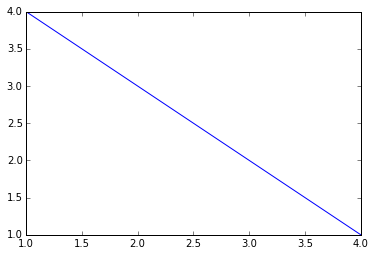

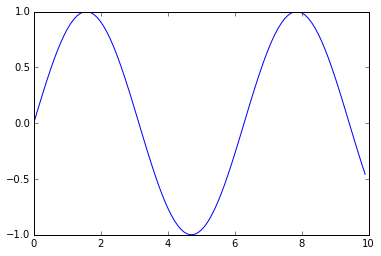

In [64]:
from pylab import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
a=array([1,2,3,4])
b=array([4,3,2,1])
plot(a,b)
show()
t1=arange(0.0,10.0,0.1)
plot(t1,sin(t1))
show()

이 절에서는 확률 분포를 검사하는 두가지 다른 방식들을 소개한다. 

1. 누적 활률 <br>
누적 확률 그래프는 주어진 값 이하의 결과 확률을 표시한다. <br> 


In [67]:
def cumulativegraph(data,vec1,high,k=5,weightf=gaussian):
  t1=arange(0.0,high,0.1)
  cprob=array([probguess(data,vec1,0,v,k,weightf) for v in t1])
  plot(t1,cprob)
  show()

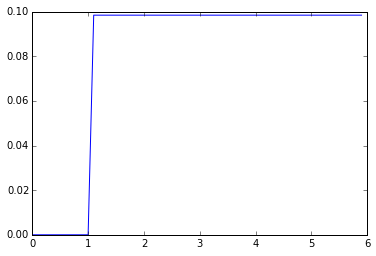

In [69]:
data=wineset3()
cumulativegraph(data,(1,1),6)

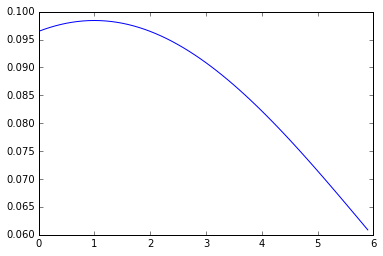

In [72]:
probabilitygraph(data,(1,1),6)